A Basic Neural Network using the MNIST dataset

This network has 2 hidden layers with the first having 300 units and the second 100 units.
Parameters are defined in the code. The Optimizer is RMSProp, used for momentum. Regularization is applied.

ghh 2/24/2017


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # to plot cost
%matplotlib inline

import tensorflow as tf

from datetime import datetime

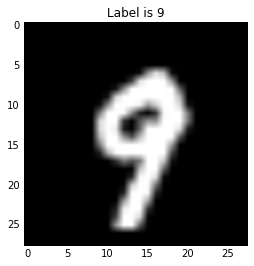

In [9]:
#Visualization

data = pd.read_csv('MNISTtrain.csv')
labels = data['label']
features = data.drop(['label'], axis = 1)

#isolates an example to use
location = 28 #<--- use me

row = features.iloc[location]
label = labels.iloc[location]

sample = np.array(row).reshape(28,28)

plt.title('Label is {}'.format(label))
plt.imshow(sample, cmap = 'gray')
plt.show()


In [18]:
def normalized_data():
    print "Retrieving and Normalizing Data"
    data = pd.read_csv('MNISTtrain.csv')
    data = data.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]
    mean = np.mean(X, axis = 0)
    std = np.std(X, axis = 0)
    np.place(std, std == 0, 1) #because you can't divide by 0
    normalized_X = (X - mean)/std
    return normalized_X, Y

def one_hot_encoding(y):
    N = len(y)
    K = max(y) + 1
    indicator_matrix = np.zeros((N,K))
    for i in xrange(N):
        indicator_matrix[i, y[i]] = 1
    return indicator_matrix    

def error_rate(p, t):
    return np.mean(p != t)

In [23]:
def main():
    
    lr = 0.00001 
    reg = 0.01 
    
    X, Y = normalized_data() 
    
    #Split the data
    Xtrain = X[:-1000, :]
    Xtest = X[-1000:, :]
    Ytrain = Y[:-1000]
    Ytest = Y[-1000:]
    
    Ytrain_onehot = one_hot_encoding(Ytrain)
    Ytest_onehot = one_hot_encoding(Ytest)
    
    N, D = Xtrain.shape
    
    #Batch Setup
    iterations = 15 
    print_iter = 10 
    
    batch_size = 500
    n_batches = N / batch_size #82
    
    #2 Hidden Layers
    M1 = 300
    M2 = 100
    
    #Output possibilities
    K = max(Ytest) + 1
    
    #Initialize Weights and Biases for each layer
    w1_init = np.random.randn(D, M1) / 28
    b1_init = np.zeros(M1)
    w2_init = np.random.randn(M1, M2) / np.sqrt(M1)
    b2_init = np.zeros(M2)
    w3_init = np.random.randn(M2, K) / np.sqrt(M2)
    b3_init = np.zeros(K)
    
    #The inputs and targets
    X = tf.placeholder(tf.float32, shape = (None, D), name = 'X')
    T = tf.placeholder(tf.float32, shape = (None, K), name = 'T')
    
    #Weights and Bias
    W1 = tf.Variable(w1_init.astype(np.float32))
    b1 = tf.Variable(b1_init.astype(np.float32))
    W2 = tf.Variable(w2_init.astype(np.float32))
    b2 = tf.Variable(b2_init.astype(np.float32))
    W3 = tf.Variable(w3_init.astype(np.float32))
    b3 = tf.Variable(b3_init.astype(np.float32))
    
    #Forward Prop
    Z1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    Z2 = tf.nn.relu(tf.matmul(Z1, W2) + b2)
    Y_logits = tf.matmul(Z2, W3) + b3

    #Cost Function
    cost_function = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(Y_logits, T)) #both are NxK matrix
    
    #Optimizer
    optimizer = tf.train.RMSPropOptimizer(lr, decay = 0.99, momentum = 0.9).minimize(cost_function)
    
    predicted_labels = tf.argmax(Y_logits, 1)
    
    cost_range = []
    
    t0 = datetime.now()
    
    #Initialize tf session
    init = tf.initialize_all_variables()
    with tf.Session() as session:
        session.run(init)
        
        #Learning loop
        #Batches are size 500. We will go through all 82 batches 15 times.
        for i in xrange(iterations):
            for j in xrange(n_batches):
                X_batch = Xtrain[j*batch_size:(j*batch_size + batch_size),]
                Y_batch = Ytrain_onehot[j*batch_size:(j*batch_size + batch_size),]

                #Train it. This is the magic
                session.run(optimizer, feed_dict={X: X_batch, T: Y_batch})

                #For results
                if j % print_iter == 0:
                    #Track the cost function of the testing data. No training.
                    test_cost = session.run(cost_function, feed_dict={X: Xtest, T: Ytest_onehot})
                    test_prediction = session.run(predicted_labels, feed_dict={X: Xtest})
                    error = error_rate(test_prediction, Ytest)
                    
                    accuracy = 1 - error

                    print('Iteration i={}, Batch j={}, Cost {:.3f} / Error {:.3f}, Accuracy {:.1f}%'.format(
                            i, j, test_cost, error, accuracy*100))

                    cost_range.append(test_cost)
        
    print "Elapsted time for training model:", datetime.now() - t0
    
    plt.plot(cost_range)
    plt.show()



Retrieving and Normalizing Data


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Iteration i=0, Batch j=0, Cost 2421.586 / Error 0.912, Accuracy 8.8%
Iteration i=0, Batch j=10, Cost 2183.834 / Error 0.734, Accuracy 26.6%
Iteration i=0, Batch j=20, Cost 1888.882 / Error 0.477, Accuracy 52.3%
Iteration i=0, Batch j=30, Cost 1615.393 / Error 0.373, Accuracy 62.7%
Iteration i=0, Batch j=40, Cost 1366.446 / Error 0.308, Accuracy 69.2%
Iteration i=0, Batch j=50, Cost 1159.637 / Error 0.252, Accuracy 74.8%
Iteration i=0, Batch j=60, Cost 995.292 / Error 0.219, Accuracy 78.1%
Iteration i=0, Batch j=70, Cost 865.647 / Error 0.200, Accuracy 80.0%
Iteration i=0, Batch j=80, Cost 764.504 / Error 0.186, Accuracy 81.4%
Iteration i=1, Batch j=0, Cost 746.921 / Error 0.182, Accuracy 81.8%
Iteration i=1, Batch j=10, Cost 671.738 / Error 0.173, Accuracy 82.7%
Iteration i=1, Batch j=20, Cost 612.081 / Error 0.161, Accuracy 83.9%
Iteration i=1, Batch j=30, Cost 564.511 / Error 0.154, Accuracy 84.6%
Iteration i=1, Batch j=40, Cost 525.840 / Error 0.149, Accuracy 85.1%
Iteration i=1, Ba

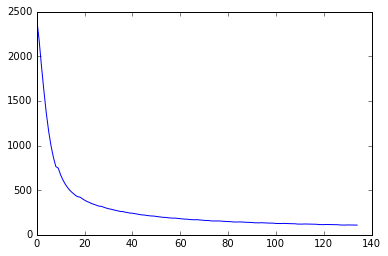

In [24]:
if __name__ == '__main__':
    main()